In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Estimated fs: 100.00 Hz (dt ~ 10.00 ms)
Reps detected: 2
Rep 1: start=2.30s end=6.26s dur=3.96s peak=0.762 rad/s @ 3.57s
Rep 2: start=6.44s end=12.22s dur=5.78s peak=0.352 rad/s @ 11.57s


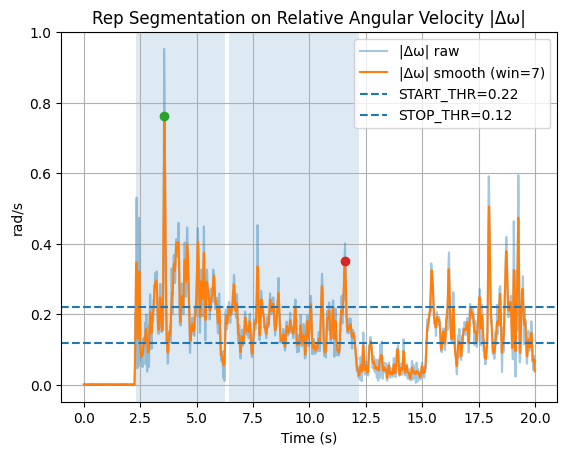

In [3]:
CSV_PATH = "dual_mpu_capture.csv"

# ---------- Tunables (start here) ----------
SAMPLE_HZ_GUESS = 100          # used if timestamps have jitter
SMOOTH_WIN = 7                 # moving average window (samples)

START_THR = 0.22             # rad/s  (movement start)
STOP_THR  = 0.12               # rad/s  (movement stop)  (lower = hysteresis)

MIN_REP_DUR_S = 0.15           # reject tiny bumps
MIN_REST_S    = 0.20           # must stay below STOP_THR this long to end rep
# ------------------------------------------

def moving_avg(x, win):
    if win <= 1:
        return x.copy()
    k = np.ones(win) / win
    return np.convolve(x, k, mode="same")

def main():
    df = pd.read_csv(CSV_PATH)
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna().reset_index(drop=True)

    # time axis
    t = (df["T_US"] - df["T_US"].iloc[0]) / 1e6
    dt = np.median(np.diff(t)) if len(t) > 2 else 1.0 / SAMPLE_HZ_GUESS
    fs = 1.0 / dt if dt > 0 else SAMPLE_HZ_GUESS

    # gyro vectors
    w1 = df[["G1X","G1Y","G1Z"]].to_numpy()
    w2 = df[["G2X","G2Y","G2Z"]].to_numpy()

    # relative angular velocity magnitude
    dw_mag = np.linalg.norm(w1 - w2, axis=1)
    dw_s   = moving_avg(dw_mag, SMOOTH_WIN)

    # convert time thresholds to samples
    min_rep_n  = int(np.ceil(MIN_REP_DUR_S * fs))
    min_rest_n = int(np.ceil(MIN_REST_S * fs))

    # ---------- State machine ----------
    # 0 = idle, 1 = in-rep, 2 = cooldown(rest-confirm)
    state = 0
    reps = []

    rep_start_i = None
    peak_i = None
    peak_val = -np.inf
    below_count = 0

    for i in range(len(dw_s)):
        v = dw_s[i]

        if state == 0:  # idle
            if v >= START_THR:
                state = 1
                rep_start_i = i
                peak_i = i
                peak_val = v
                below_count = 0

        elif state == 1:  # in-rep
            # track peak
            if v > peak_val:
                peak_val = v
                peak_i = i

            # check for stop condition (below STOP_THR for long enough)
            if v <= STOP_THR:
                below_count += 1
                if below_count >= min_rest_n:
                    rep_end_i = i
                    # validate duration
                    if rep_end_i - rep_start_i >= min_rep_n:
                        reps.append({
                            "start_i": rep_start_i,
                            "end_i": rep_end_i,
                            "peak_i": peak_i,
                            "start_t": float(t.iloc[rep_start_i]),
                            "end_t": float(t.iloc[rep_end_i]),
                            "peak_t": float(t.iloc[peak_i]),
                            "peak_dw": float(peak_val),
                            "dur_s": float(t.iloc[rep_end_i] - t.iloc[rep_start_i]),
                        })
                    state = 0
                    rep_start_i = None
                    peak_i = None
                    peak_val = -np.inf
                    below_count = 0
            else:
                below_count = 0

    # ---------- Print summary ----------
    print(f"Estimated fs: {fs:.2f} Hz (dt ~ {dt*1000:.2f} ms)")
    print(f"Reps detected: {len(reps)}")
    for k, r in enumerate(reps, 1):
        print(f"Rep {k}: start={r['start_t']:.2f}s end={r['end_t']:.2f}s "
              f"dur={r['dur_s']:.2f}s peak={r['peak_dw']:.3f} rad/s @ {r['peak_t']:.2f}s")

    # ---------- Plot ----------
    plt.figure()
    plt.plot(t, dw_mag, alpha=0.4, label="|Δω| raw")
    plt.plot(t, dw_s, label=f"|Δω| smooth (win={SMOOTH_WIN})")
    plt.axhline(START_THR, linestyle="--", label=f"START_THR={START_THR}")
    plt.axhline(STOP_THR, linestyle="--", label=f"STOP_THR={STOP_THR}")

    for r in reps:
        plt.axvspan(r["start_t"], r["end_t"], alpha=0.15)
        plt.plot(r["peak_t"], r["peak_dw"], marker="o")

    plt.title("Rep Segmentation on Relative Angular Velocity |Δω|")
    plt.xlabel("Time (s)")
    plt.ylabel("rad/s")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()